# Resnet from scratch

In [1]:
from fastai.vision import *

## MNIST Data

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

[WindowsPath('C:/Users/Javi/.fastai/data/mnist_png/testing'),
 WindowsPath('C:/Users/Javi/.fastai/data/mnist_png/training')]

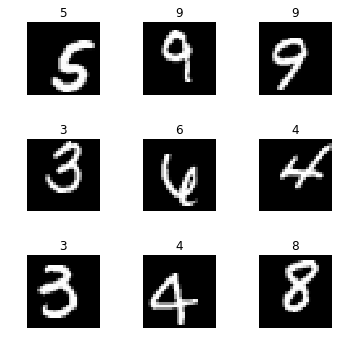

In [24]:
defaults.cmap='gray' # 'binary'
tmfs = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
bs   = 128
# not using imagenet_stats because not using pretrained model

il = ImageItemList.from_folder(path, convert_mode='L')
sd = il.split_by_folder(train='training', valid='testing') # 2. Split in train/val
ll = sd.label_from_folder()                                # 3. Label it
ll = ll.transform(tmfs)                                    # 4. Add transforms
data = ll.databunch(bs=bs).normalize()                     # 5. Create data bunch

data.show_batch(rows=3, figsize=(5,5))

## Basic CNN
With stride 2 convs and bachnorm.

In [25]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [26]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [27]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


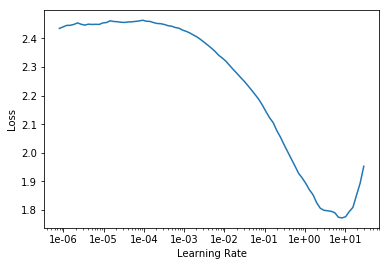

In [33]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.217599,0.268518,0.910900
2,0.129914,0.111429,0.966800
3,0.074019,0.038402,0.988100


## Refactor

In [35]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [36]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.232161,0.143639,0.955900
2,0.181608,0.238614,0.921500
3,0.167836,0.136467,0.956700
4,0.148611,0.144851,0.955600
5,0.118185,0.114009,0.961400
6,0.105867,0.065028,0.979500
7,0.086344,0.063759,0.978500
8,0.068848,0.039597,0.987000
9,0.055124,0.031100,0.989500
10,0.045829,0.029691,0.989200


## Resnet
Resnet block: 2 convolutionx with original x, are **summed**.

In [39]:
model = nn.Sequential(
    conv_layer(1,8,stride=2),
    res_block(8),
    conv_layer(8,16,stride=2),
    res_block(16),
    conv_layer(16,32,stride=2),
    res_block(32),
    ,conv_layer(32,16,stride=2),
    res_block(16),
    conv_layer(16,10,stride=2),
    Flatten()
)

In [44]:
def conv_and_res(ni,nf):
    return nn.Sequential(conv_layer(ni, nf, stride=2), res_block(nf))

model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv_layer(16, 10, stride=2),
    Flatten()
)

In [45]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [46]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## Densenet
Densenet block: 2 convolutions with original x, are **concatenated**.

In [50]:
densenet = nn.Sequential(
    conv_layer(1,8,stride=2),
    res_block(8, dense=True),
    conv_layer(8,16,stride=2),
    res_block(16, dense=True),
    conv_layer(16,32,stride=2),
    res_block(32, dense=True),
    conv_layer(32,16,stride=2),
    res_block(16, dense=True),
    conv_layer(16,10,stride=2),
    Flatten()
)

In [51]:
learn = Learner(data, densenet)
print(learn.summary())

RuntimeError: Given groups=1, weight of size [16, 8, 3, 3], expected input[128, 16, 14, 14] to have 8 channels, but got 16 channels instead